# Analyzing on the dataset of mouse hematopoietic stem cells (mHSCs) differentiation
> The raw data are obatined from [https://blood.stemcells.cam.ac.uk/single_cell_atlas.html](https://blood.stemcells.cam.ac.uk/single_cell_atlas.html) \
> **ref.** Nestorowa, Sonia, et al. "A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation." Blood, (2016): e20-e31.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import scanpy as sc
import scanpy.external as sce
sc.settings.verbosity = 2 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150, dpi_save=600, frameon=False, figsize=(3, 3), fontsize=11, facecolor='white', color_map = 'viridis_r')

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Reset random seed
np.random.seed(2022)

set the `R_HOME` and `R_USER` environment variables

In [2]:
import os
os.environ['R_HOME'] = 'D:/Software/R/R-4.2.2'
os.environ['R_USER'] = 'D:/Software/anaconda3/envs/singlecell/Lib/site-packages/rpy2' 

- ## **The processed data loading and basic visualization**:

The processed '.h5ad' data can be download from: `https://zenodo.org/record/7564872`

In [4]:
adata = sc.read_h5ad('mHSC_Nestorowa_hvg3000.h5ad')
adata

AnnData object with n_obs × n_vars = 1645 × 3000
    obs: 'cell_type_STREAM', 'E_pseudotime', 'GM_pseudotime', 'L_pseudotime', 'label_info', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_STREAM_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'palantir_EigenValues', 'pca'
    obsm: 'X_draw_graph_fa', 'X_palantir_diff_comp', 'X_palantir_multiscale', 'X_pca'
    varm: 'PCs'
    layers: 'palantir_imp'
    obsp: 'connectivities', 'distances', 'palantir_diff_op'

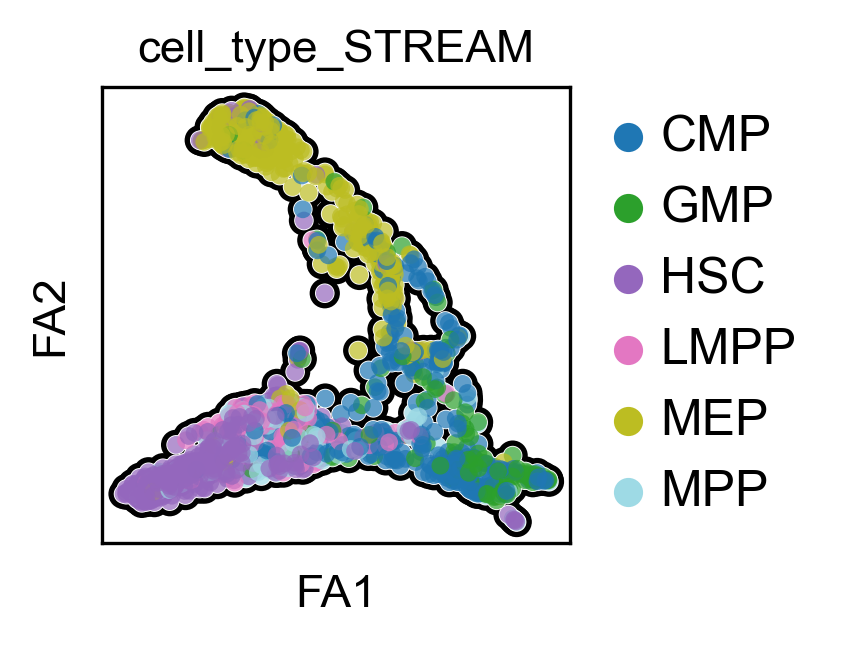

In [5]:
# Force-directed graph drawing (annotated cell clusters)
palette = {'HSC':'#9467bd','MPP':'#9edae5','CMP':'#1f77b4','GMP':'#2ca02c','MEP':'#bcbd22','LMPP':'#e377c2'} # from tab20

with rc_context({'figure.figsize': (2, 2)}):
    sc.pl.draw_graph(adata, color='cell_type_STREAM', add_outline=True, palette='tab20',
                     legend_fontsize=12, frameon=True, show=False, return_fig=True)

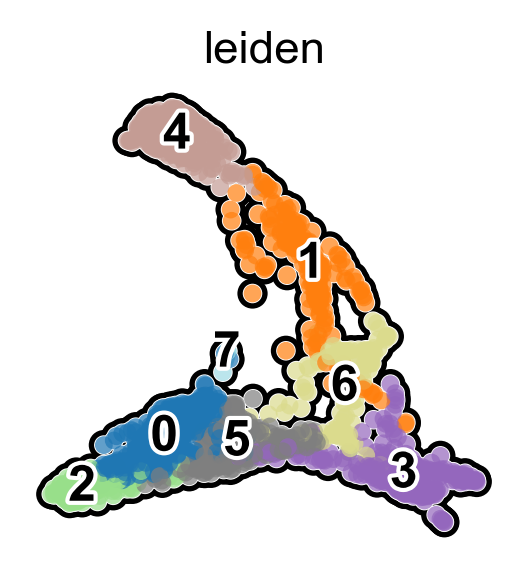

In [6]:
# Force-directed graph drawing (leiden)
with rc_context({'figure.figsize': (2, 2)}):
    sc.pl.draw_graph(adata, color='leiden', add_outline=True, legend_loc='on data', palette='tab20',
                     legend_fontsize=12, legend_fontoutline=2,frameon=False, show=True) #'viridis','tab20'

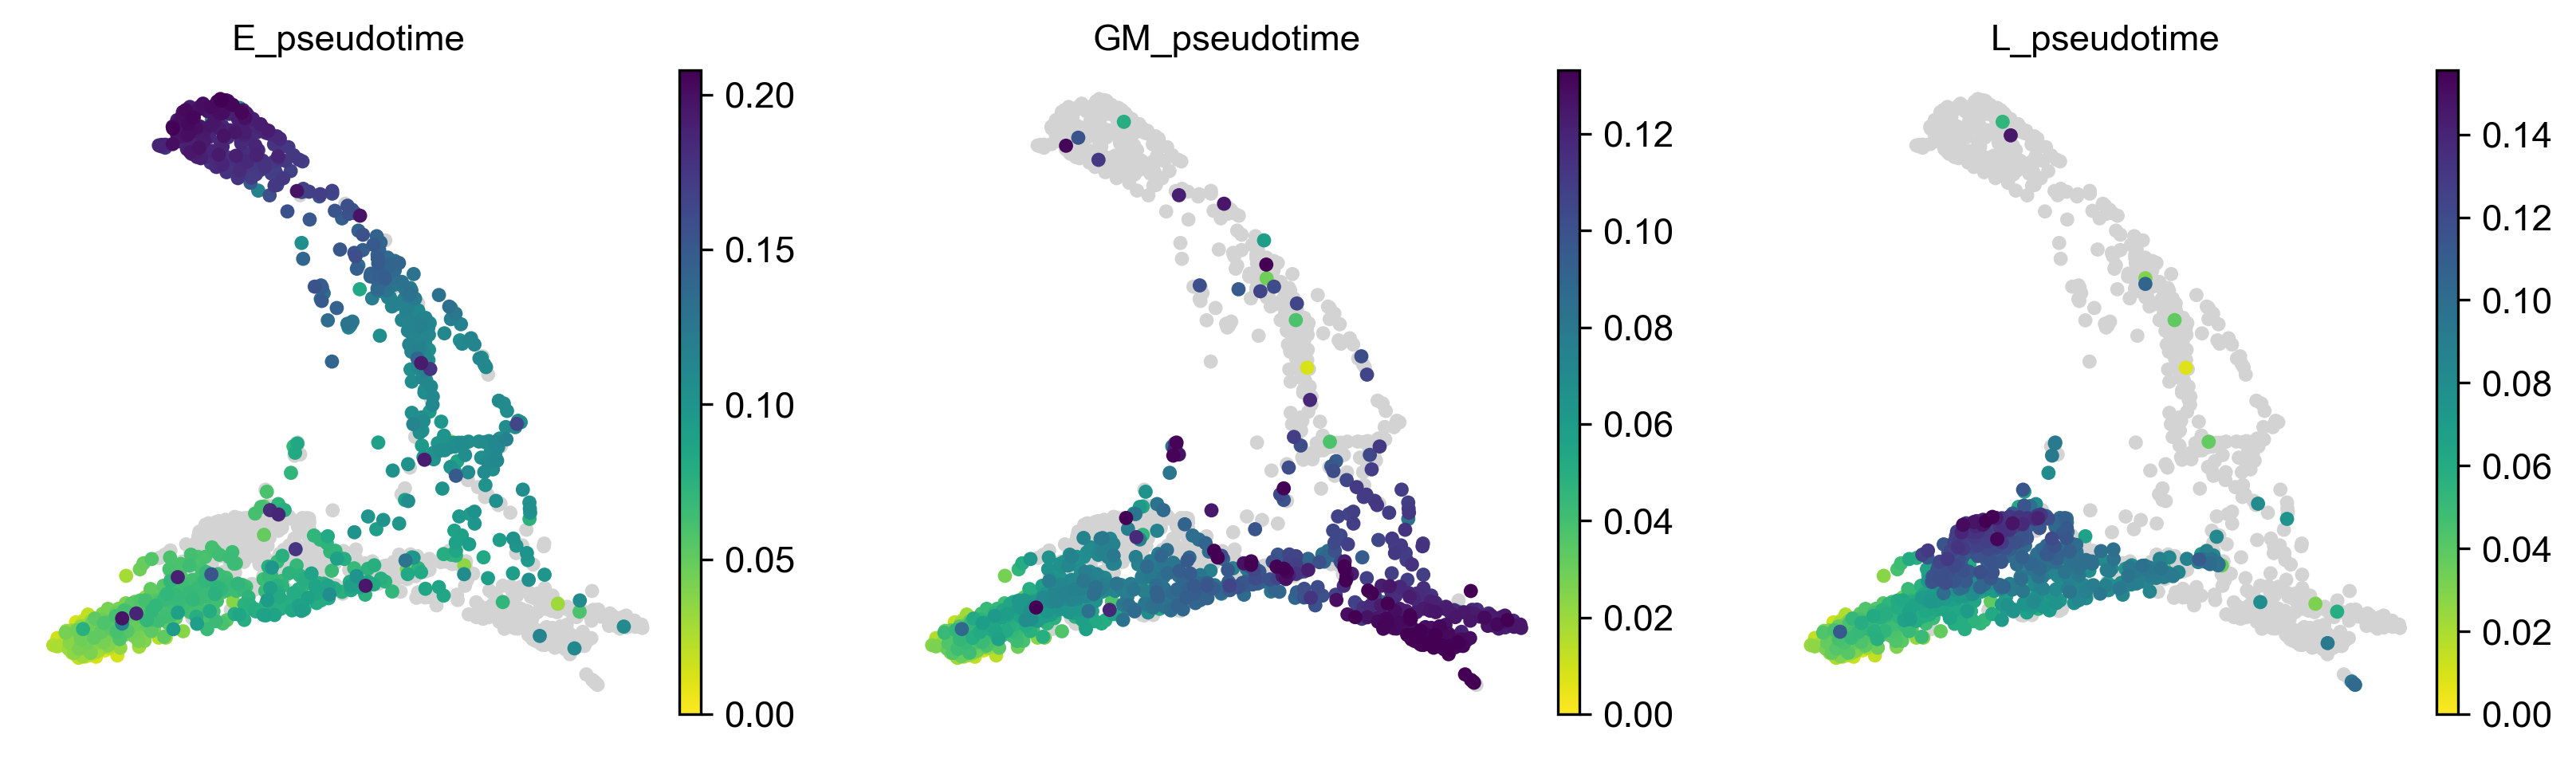

In [7]:
# Pseudo-time information
with rc_context({'figure.figsize': (3.5, 3.5)}):
    sc.pl.draw_graph(adata, color=['E_pseudotime','GM_pseudotime','L_pseudotime'], ncols=3)

- ## **Analyzing the results obtained by CEFCON**:

We recommend to use GPU for running CEFCON. We have run the results in advance. Here, we only load the result data for analysis and visualization.

The result files can be downloaded from: `https://zenodo.org/record/7564872`

In [8]:
# Results are in this file path
results_dir = './results/'

### - Top 20 Driver regulators

In [9]:
# load result data
drivers_E = pd.read_csv(results_dir + 'Result_DriverRegulators_mHSC-E.csv')
drivers_GM = pd.read_csv(results_dir + 'Result_DriverRegulators_mHSC-GM.csv')
drivers_L = pd.read_csv(results_dir + 'Result_DriverRegulators_mHSC-L.csv')

drivers_E.loc[:,'Unnamed: 0'] = drivers_E.loc[:,'Unnamed: 0'].str.capitalize()
drivers_GM.loc[:,'Unnamed: 0'] = drivers_GM.loc[:,'Unnamed: 0'].str.capitalize()
drivers_L.loc[:,'Unnamed: 0'] = drivers_L.loc[:,'Unnamed: 0'].str.capitalize()

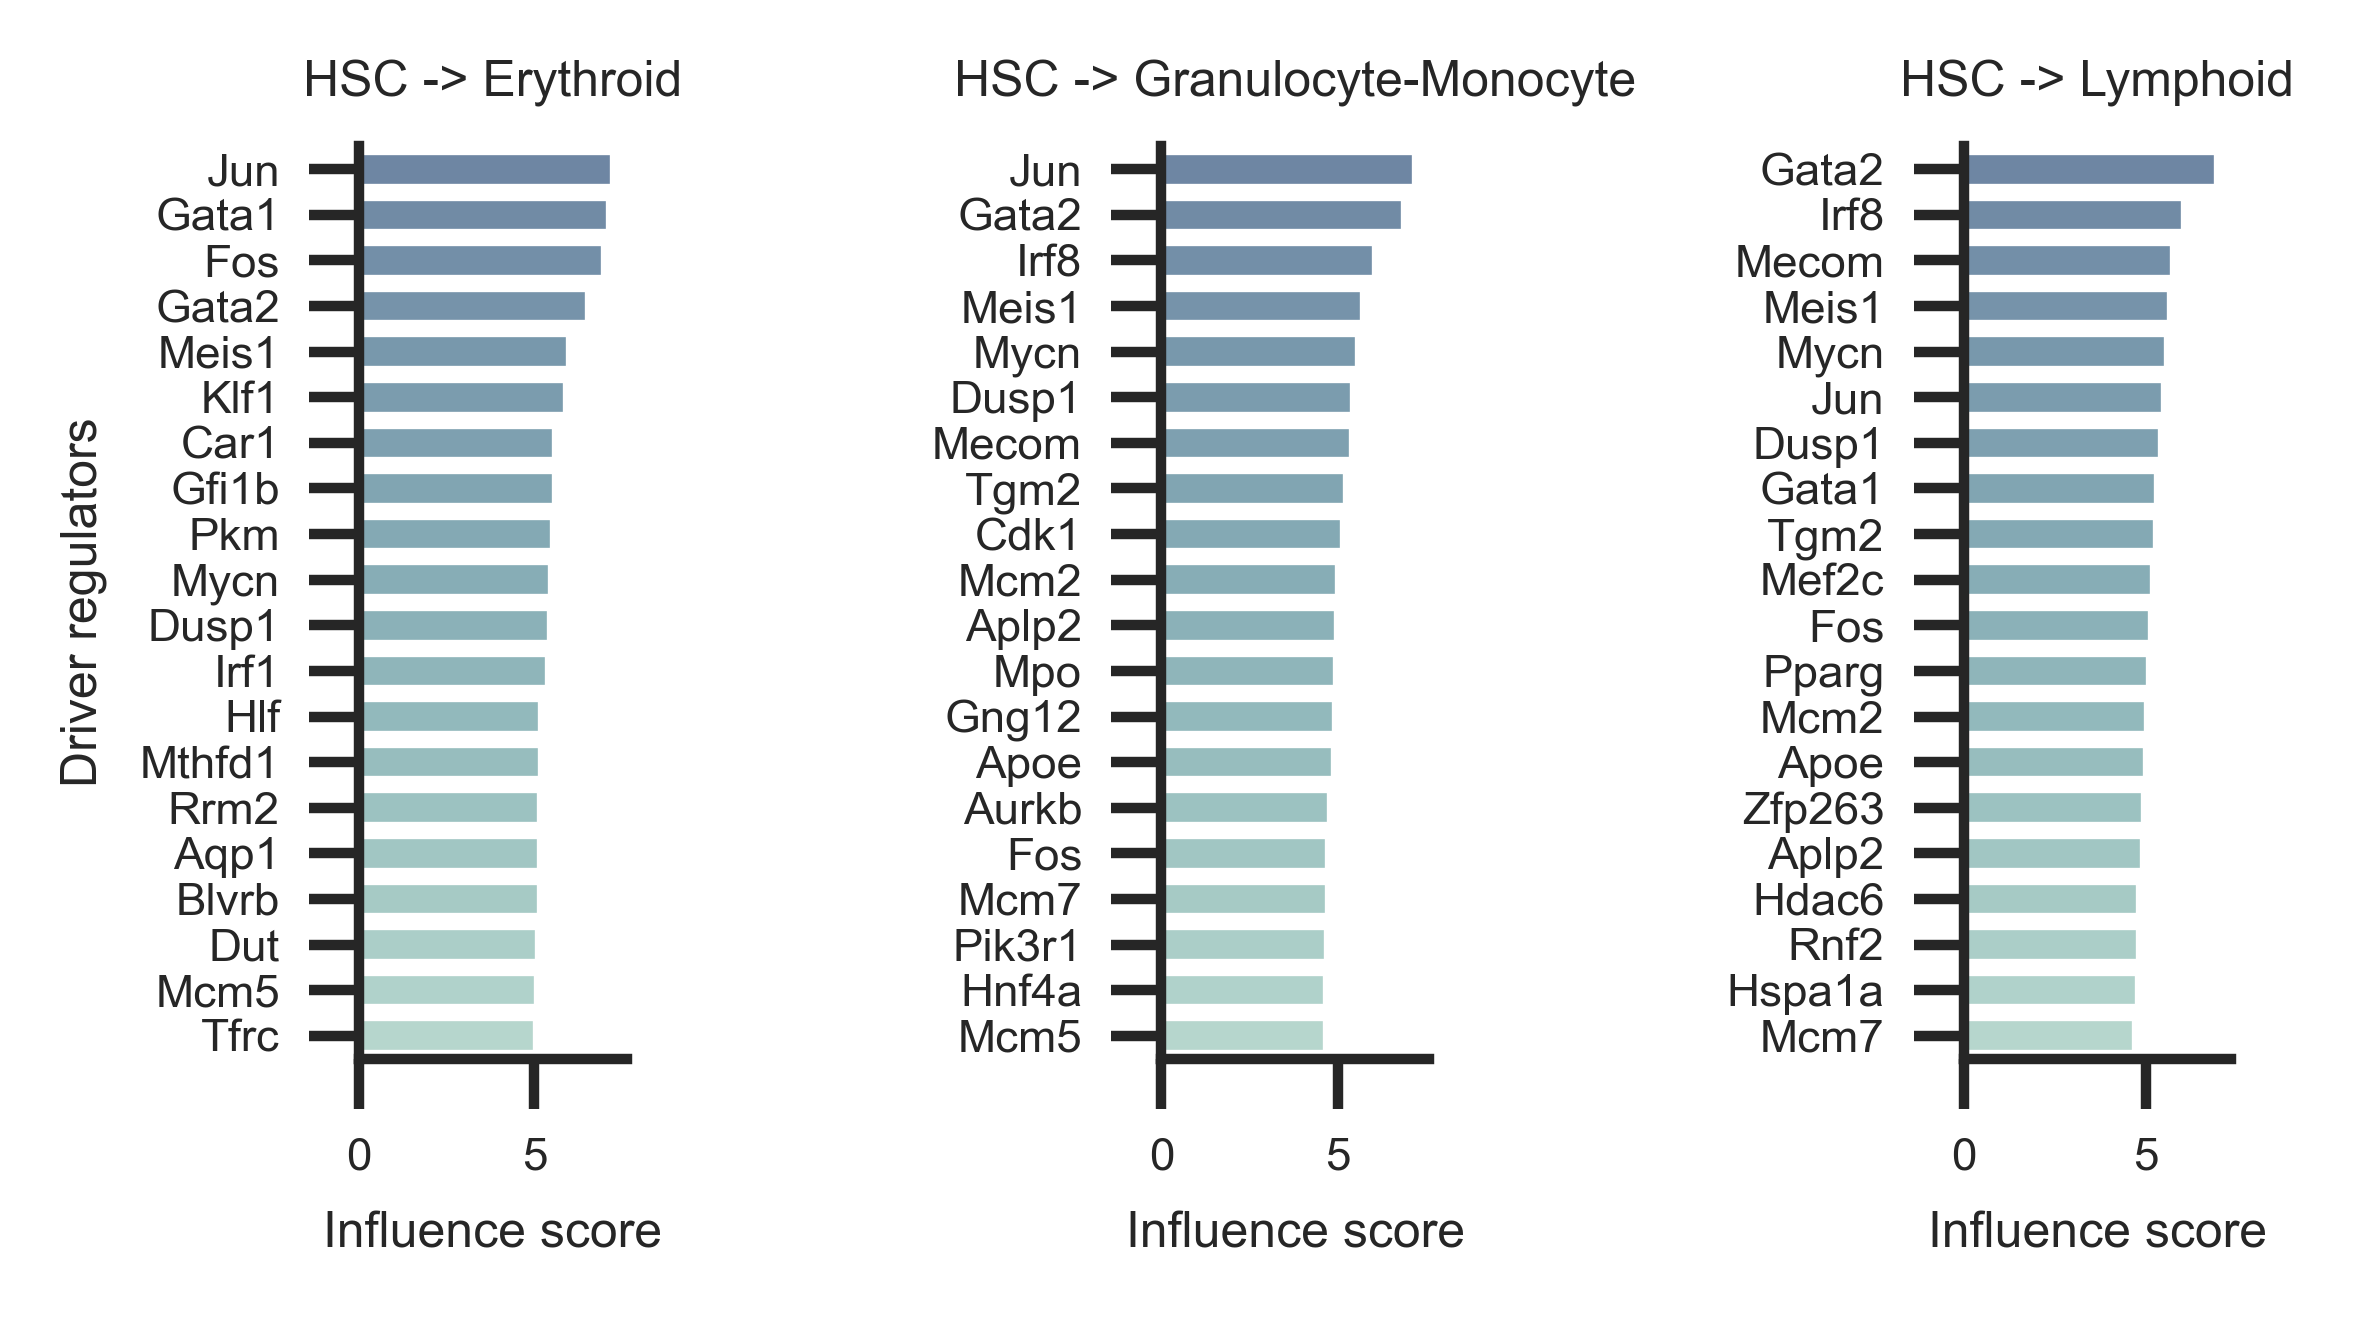

In [10]:
fig = plt.figure(dpi=300,figsize=(4,2))
sns.set_theme(style="ticks", font_scale=0.5)

fig.add_subplot(1,3,1)
ax1 = sns.barplot(x="Score", y="Unnamed: 0", data=drivers_E[0:20], orient='h', palette=sns.color_palette("ch:start=.5,rot=-.5,reverse=1,dark=0.5",23))
ax1.set_title('HSC -> Erythroid')
ax1.set_xlabel('Influence score')
ax1.set_ylabel('Driver regulators')
ax1.xaxis.set_minor_locator(ticker.NullLocator())
ax1.yaxis.set_minor_locator(ticker.NullLocator())
sns.despine()

fig.add_subplot(1,3,2)
ax2 = sns.barplot(x="Score", y="Unnamed: 0", data=drivers_GM[0:20], orient='h', palette=sns.color_palette("ch:start=.5,rot=-.5,reverse=1,dark=0.5",23))
ax2.set_title('HSC -> Granulocyte-Monocyte')
ax2.set_xlabel('Influence score')
ax2.set_ylabel('')
ax2.xaxis.set_minor_locator(ticker.NullLocator())
ax2.yaxis.set_minor_locator(ticker.NullLocator())
sns.despine()

fig.add_subplot(1,3,3)
ax3 = sns.barplot(x="Score", y="Unnamed: 0", data=drivers_L[0:20], orient='h', palette=sns.color_palette("ch:start=.5,rot=-.5,reverse=1,dark=0.5",23))
ax3.set_title('HSC -> Lymphoid')
ax3.set_xlabel('Influence score')
ax3.set_ylabel('')
ax3.xaxis.set_minor_locator(ticker.NullLocator())
ax3.yaxis.set_minor_locator(ticker.NullLocator())
sns.despine()

plt.subplots_adjust(wspace = 2)

### - Plot gene expression trends by using Palantir
`pip install palantir` for version 1.0.1 \
or \
`pip install git+https://github.com/dpeerlab/Palantir.git` for the latest version which replaced rpy2 with pyGAM for computing gene expression trends

In [11]:
import palantir

# comptue multiscale space in diffusion map space
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names))
ms_data = palantir.utils.determine_multiscale_space(dm_res)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


Determing nearest neighbor graph...
computing neighbors
    finished (0:00:15)


In [12]:
# Set the start cell and terminal states based on the pseudo-time
start_cell = adata.obs['E_pseudotime'].idxmin()
terminal_states = pd.Series(['Erythroid', 'Granulocyte-Monocyte', 'Lymphoid'],
                           index=[adata.obs['E_pseudotime'].idxmax(),
                                  adata.obs['GM_pseudotime'].idxmax(),
                                  adata.obs['L_pseudotime'].idxmax()])

In [13]:
sce.tl.palantir(
    adata,
    n_components=10,
    knn=30,
    use_adjacency_matrix=False,
    distances_key="distances",
)
pr_res = sce.tl.palantir_results(
    adata,
    early_cell=start_cell,
    terminal_states = list(terminal_states.index),
    ms_data='X_palantir_multiscale',
    num_waypoints=500,
)
#The terminal states in this dataset are renamed to reflect the known biology below
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

Palantir Diffusion Maps in progress ...
Determing nearest neighbor graph...
computing neighbors
    finished (0:00:00)
Palantir computing waypoints..
Sampling and flocking waypoints...
Time for determining waypoints: 0.003325668970743815 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.5640360593795777 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


\> Plot the gene trends: each gene is plotted in a different panel. \
This function is taken from `github/theislab/cellrank_reproducibility`

In [14]:
def plot_gene_trends(gene_trends, genes, color_mapper, figsize=None):
    """ 
    :param: gene_trends: Results of the compute_marker_trends function
    """
    sns.set_theme(style="ticks")
    # Branches and genes
    branches = list(gene_trends.keys())
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    if figsize is None:
        figsize = len(genes), 13
    fig, axes = plt.subplots(figsize=figsize, nrows=len(genes), sharex='col')
    axes = np.array(axes).reshape((-1,))
    fig.tight_layout()
    
    for i, (gene, ax) in enumerate(zip(genes, axes)):
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=color_mapper[branch], label=branch
            )
            ax.fill_between(
                trends.columns,
                trends.loc[gene, :] - stds.loc[gene, :],
                trends.loc[gene, :] + stds.loc[gene, :],
                alpha=0.1,
                color=color_mapper[branch],
            )
            ax.set_ylabel(gene)

    ax.set_xticks([0, 1])
    sns.despine()
    
    return fig

In [15]:
lineages = ['Erythroid', 'Granulocyte-Monocyte', 'Lymphoid']
colors = ['#bcbd22', '#2ca02c', '#e377c2']
genes_common = ['Meis1', 'Gata2', 'Dusp1', 'Jun', 'Fos', 'Mycn']
genes_specific = ['Klf1', 'Mpo', 'Mef2c']
color_mapper = dict(zip(lineages, colors))

In [16]:
# Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.
imp_df = palantir.utils.run_magic_imputation(adata, dm_res)
gene_trends = palantir.presults.compute_gene_trends(pr_res,
                                                    imp_df.loc[:, genes_common+genes_specific],
                                                    n_jobs=1)

Lymphoid
Time for processing Lymphoid: 0.13483922084172567 minutes
Granulocyte-Monocyte
Time for processing Granulocyte-Monocyte: 0.13386569420496622 minutes
Erythroid
Time for processing Erythroid: 0.14017048279444377 minutes


*> Plot gene expression trends of the common driver regulators* 

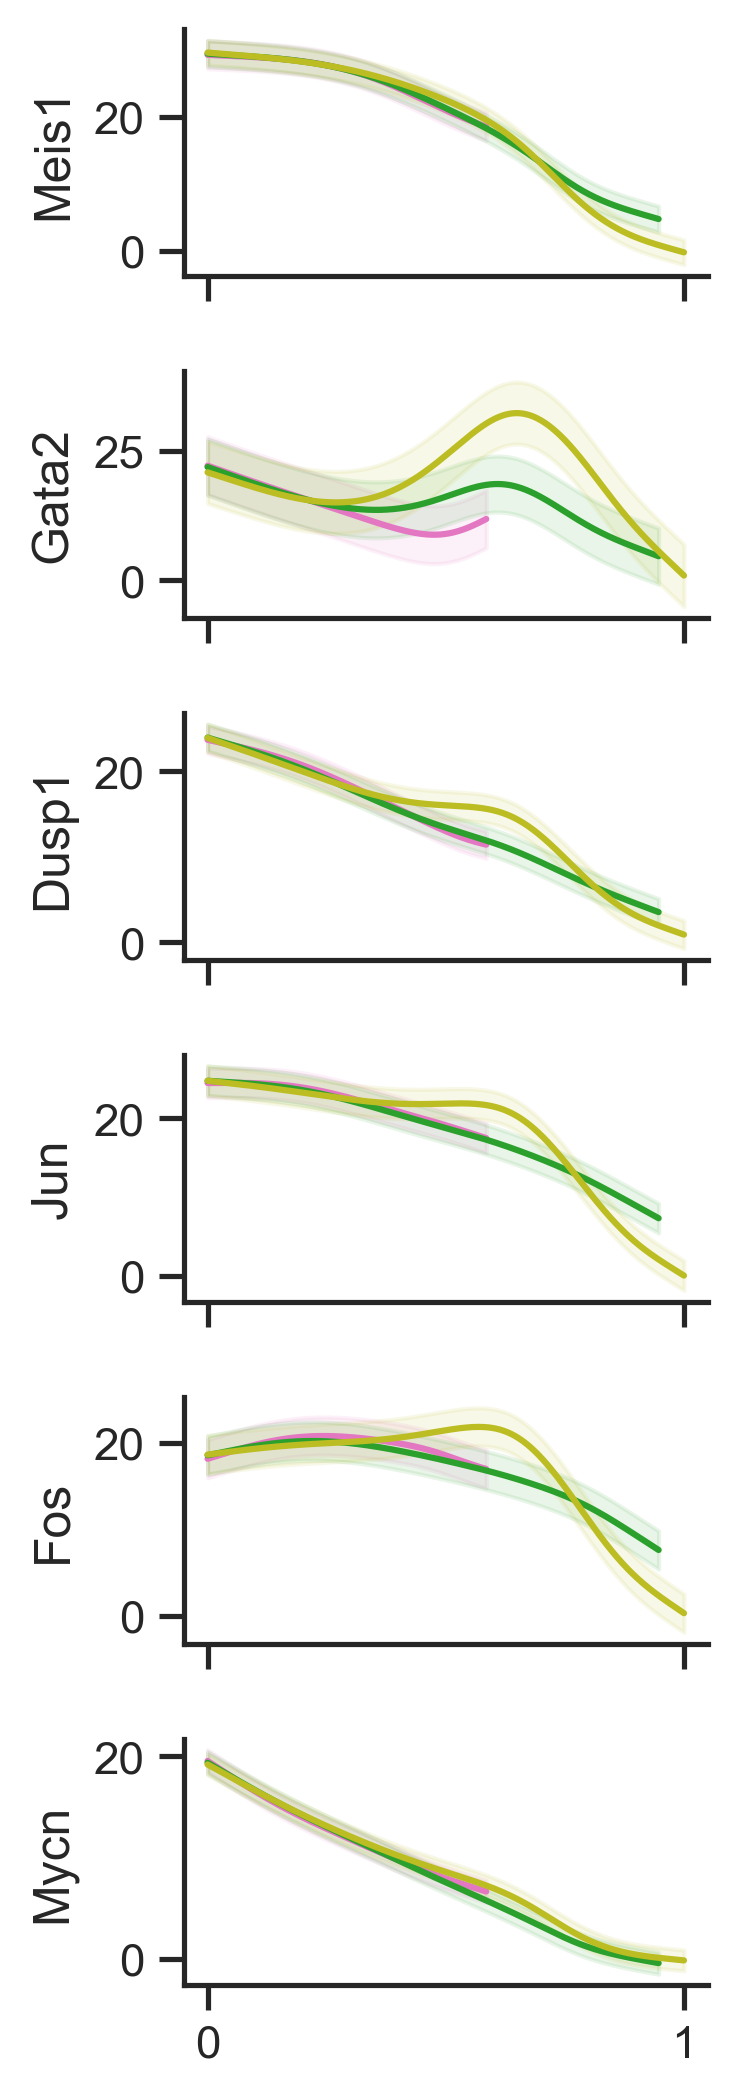

In [17]:
plot_gene_trends(gene_trends, genes_common, color_mapper, figsize=(2.6,len(genes_common)*1.2))

*> Plot gene expression trends of the specific driver regulators* 

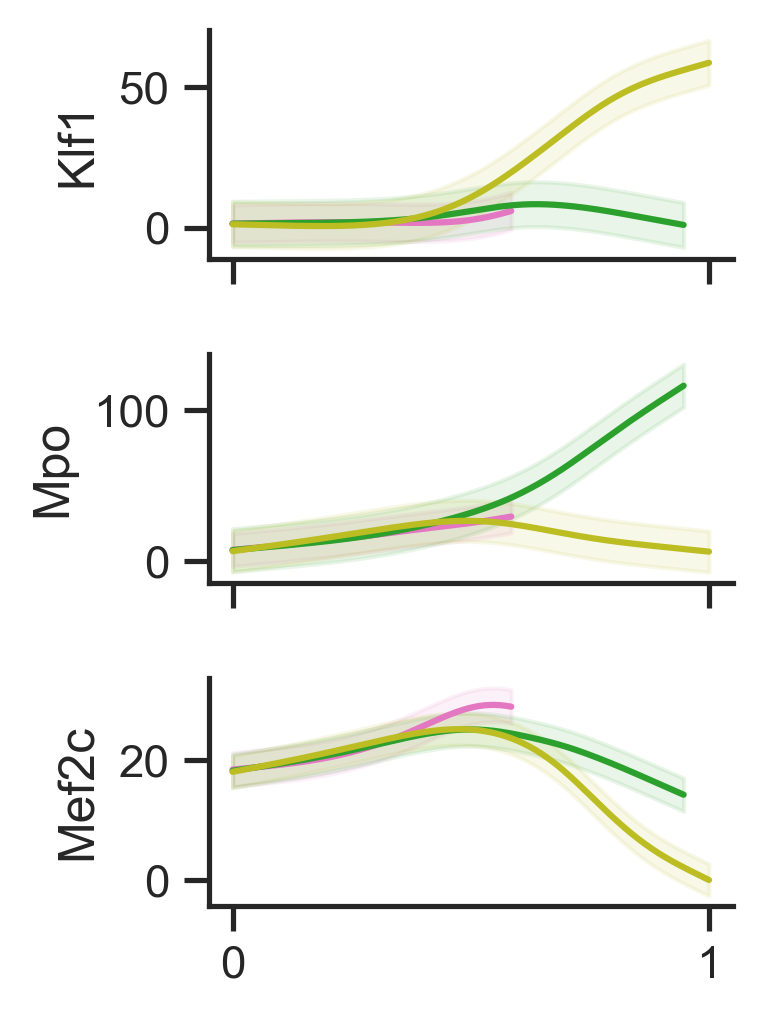

In [18]:
plot_gene_trends(gene_trends, genes_specific, color_mapper, figsize=(2.6,len(genes_specific)*1.2))

### - Regulon-like gene modules

In [19]:
from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
import pickle

# load the results of RGMs
regulons_E = pickle.load(open(results_dir + 'Result_RGM_mHSC-E.pkl', 'rb'))
regulons_GM = pickle.load(open(results_dir + 'Result_RGM_mHSC-GM.pkl', 'rb'))
regulons_L = pickle.load(open(results_dir + 'Result_RGM_mHSC-L.pkl', 'rb'))

regulon_data = {'E_pseudotime':regulons_E,'GM_pseudotime':regulons_GM,'L_pseudotime':regulons_L}

In [20]:
adata_regulon = dict()
for i,v in regulon_data.items():
    regulons = v['regulons']
    auc_mtx_all = v['aucell']
    adata_regulon[i] = adata[auc_mtx_all.index,:]
    add_scenic_metadata(adata_regulon[i], auc_mtx_all)

\> We use *`Gata2`* as an example:

In [21]:
regulon_selected = dict()
for i,v in adata_regulon.items():
    regulon_selected[i] = [k for k in v.obs.keys() if 'Gata2' in k]

computing UMAP
    finished (0:00:03)
computing UMAP
    finished (0:00:03)
computing UMAP
    finished (0:00:02)


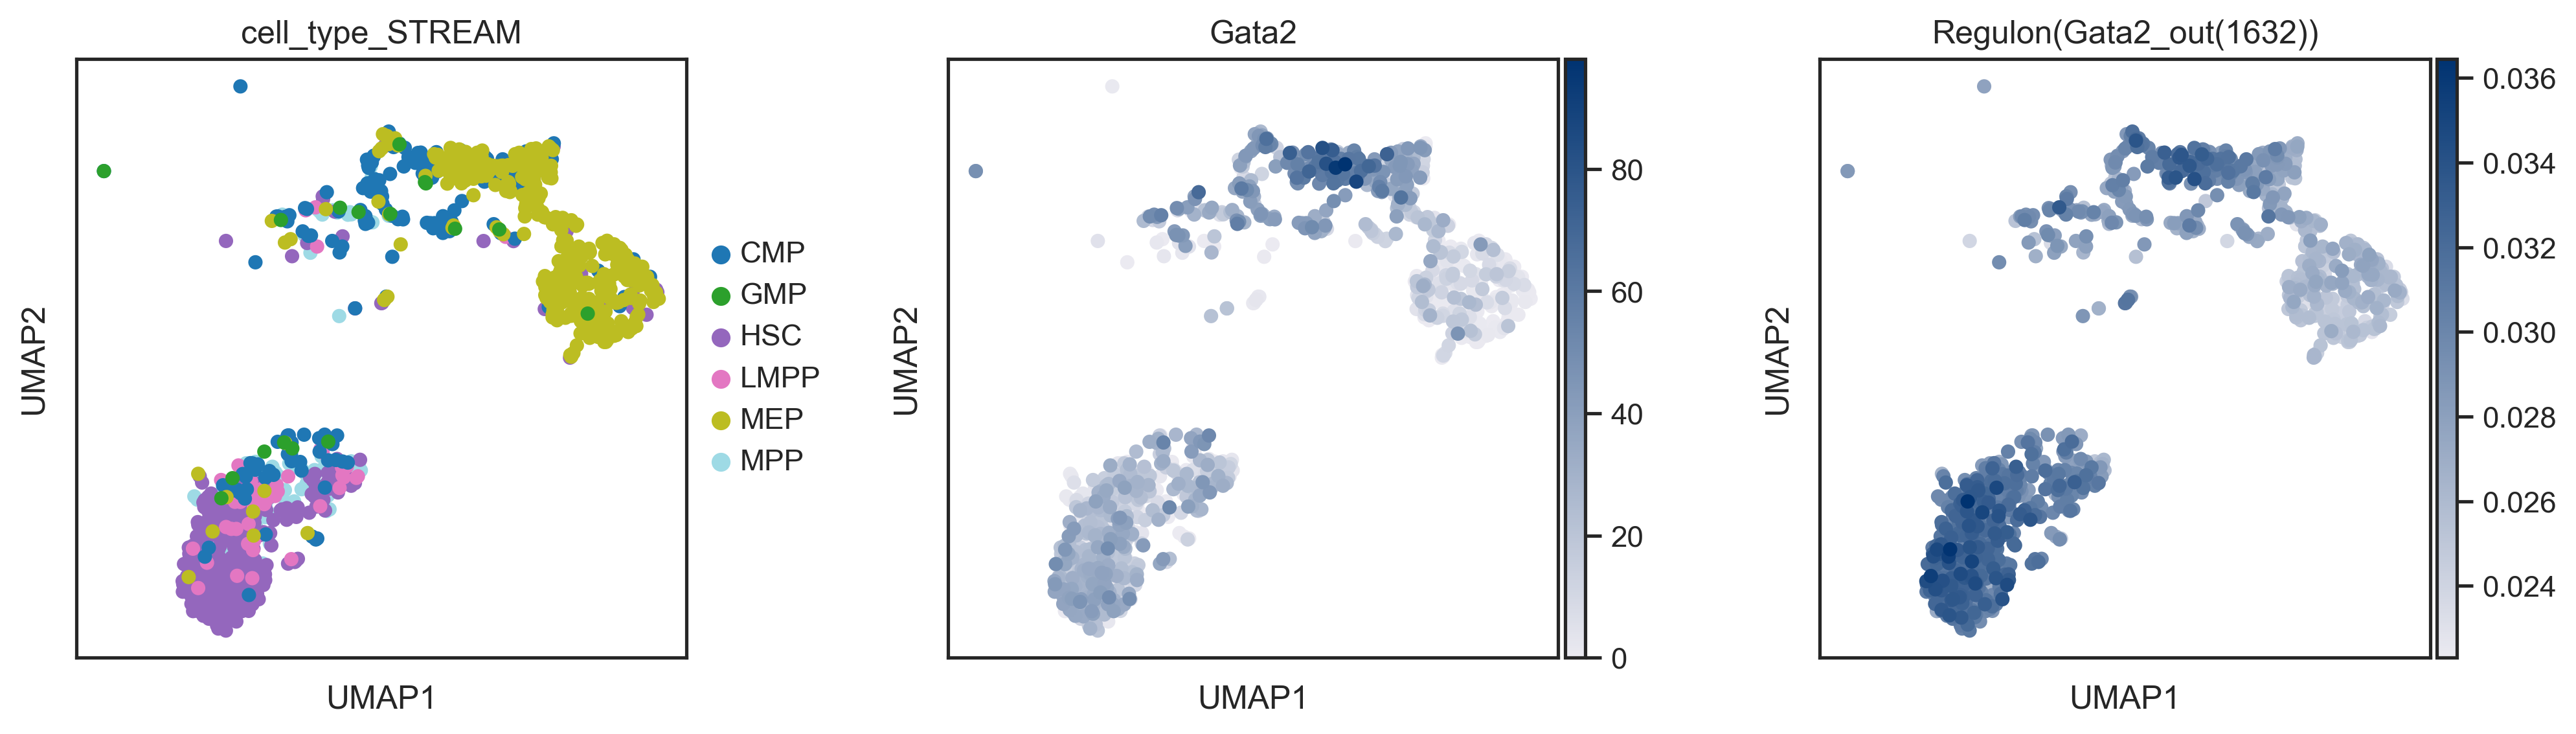

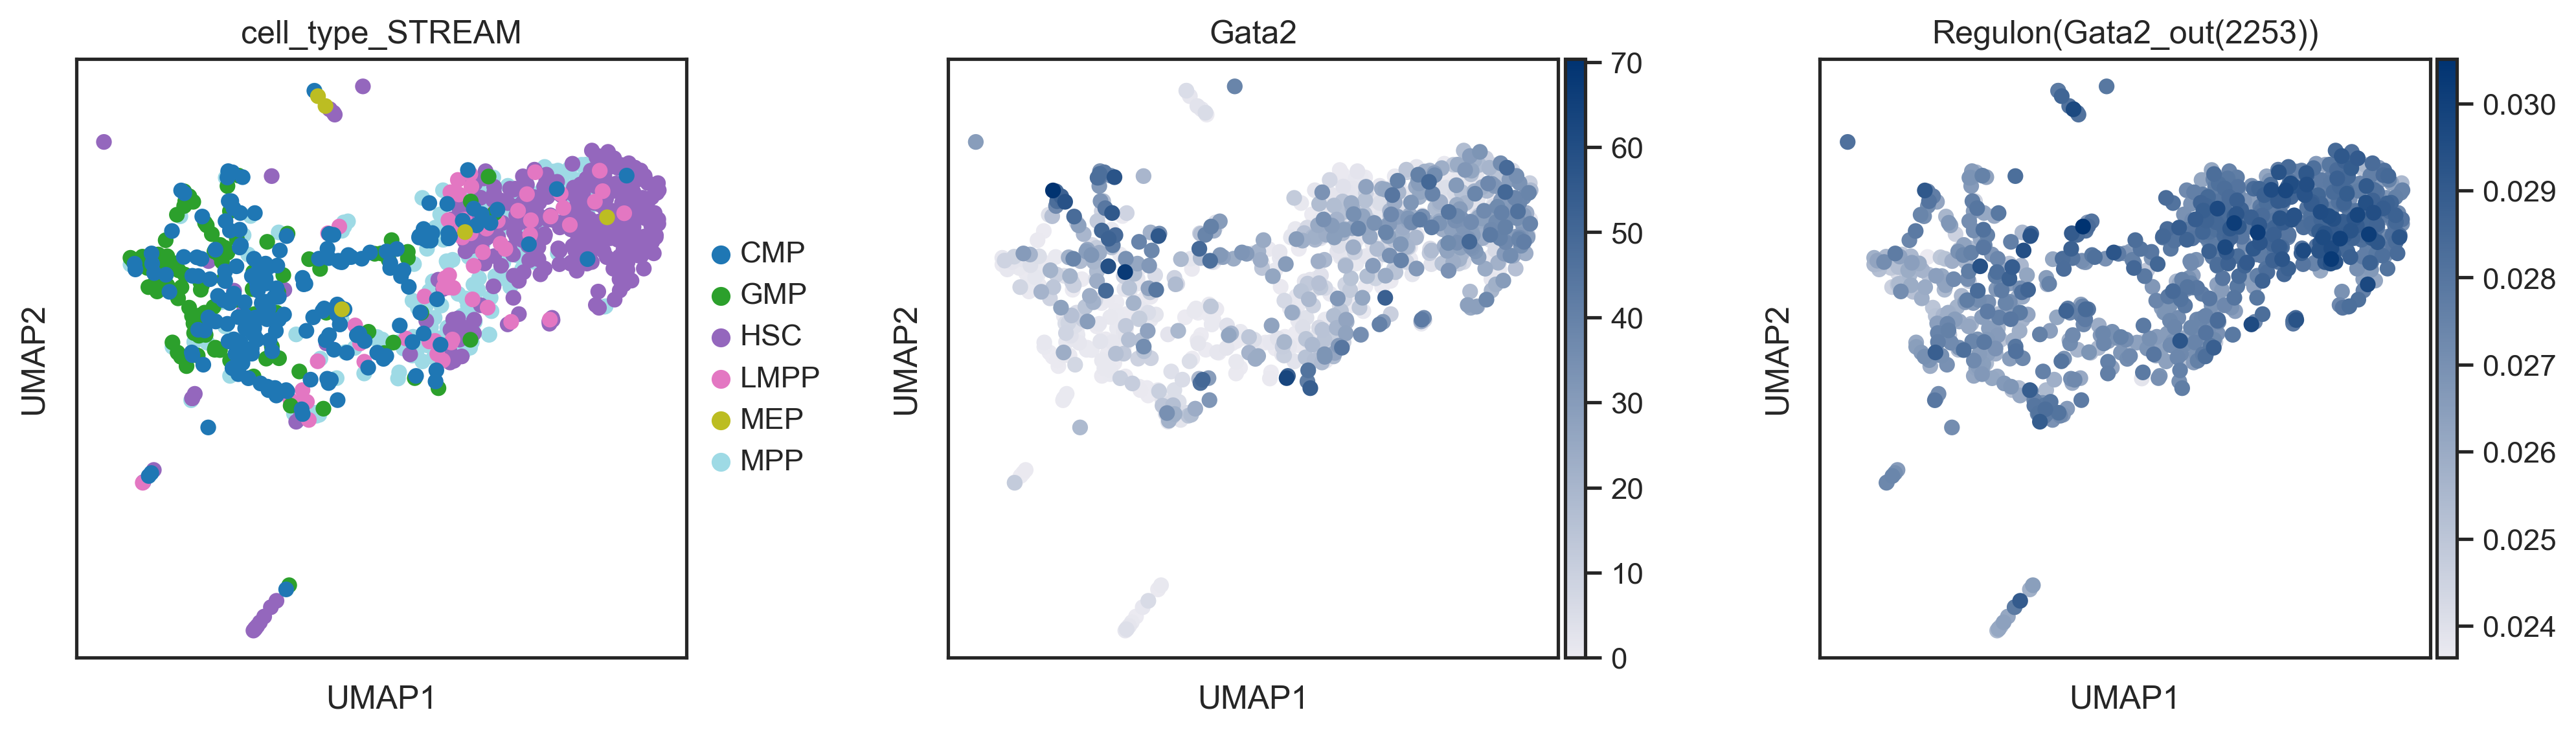

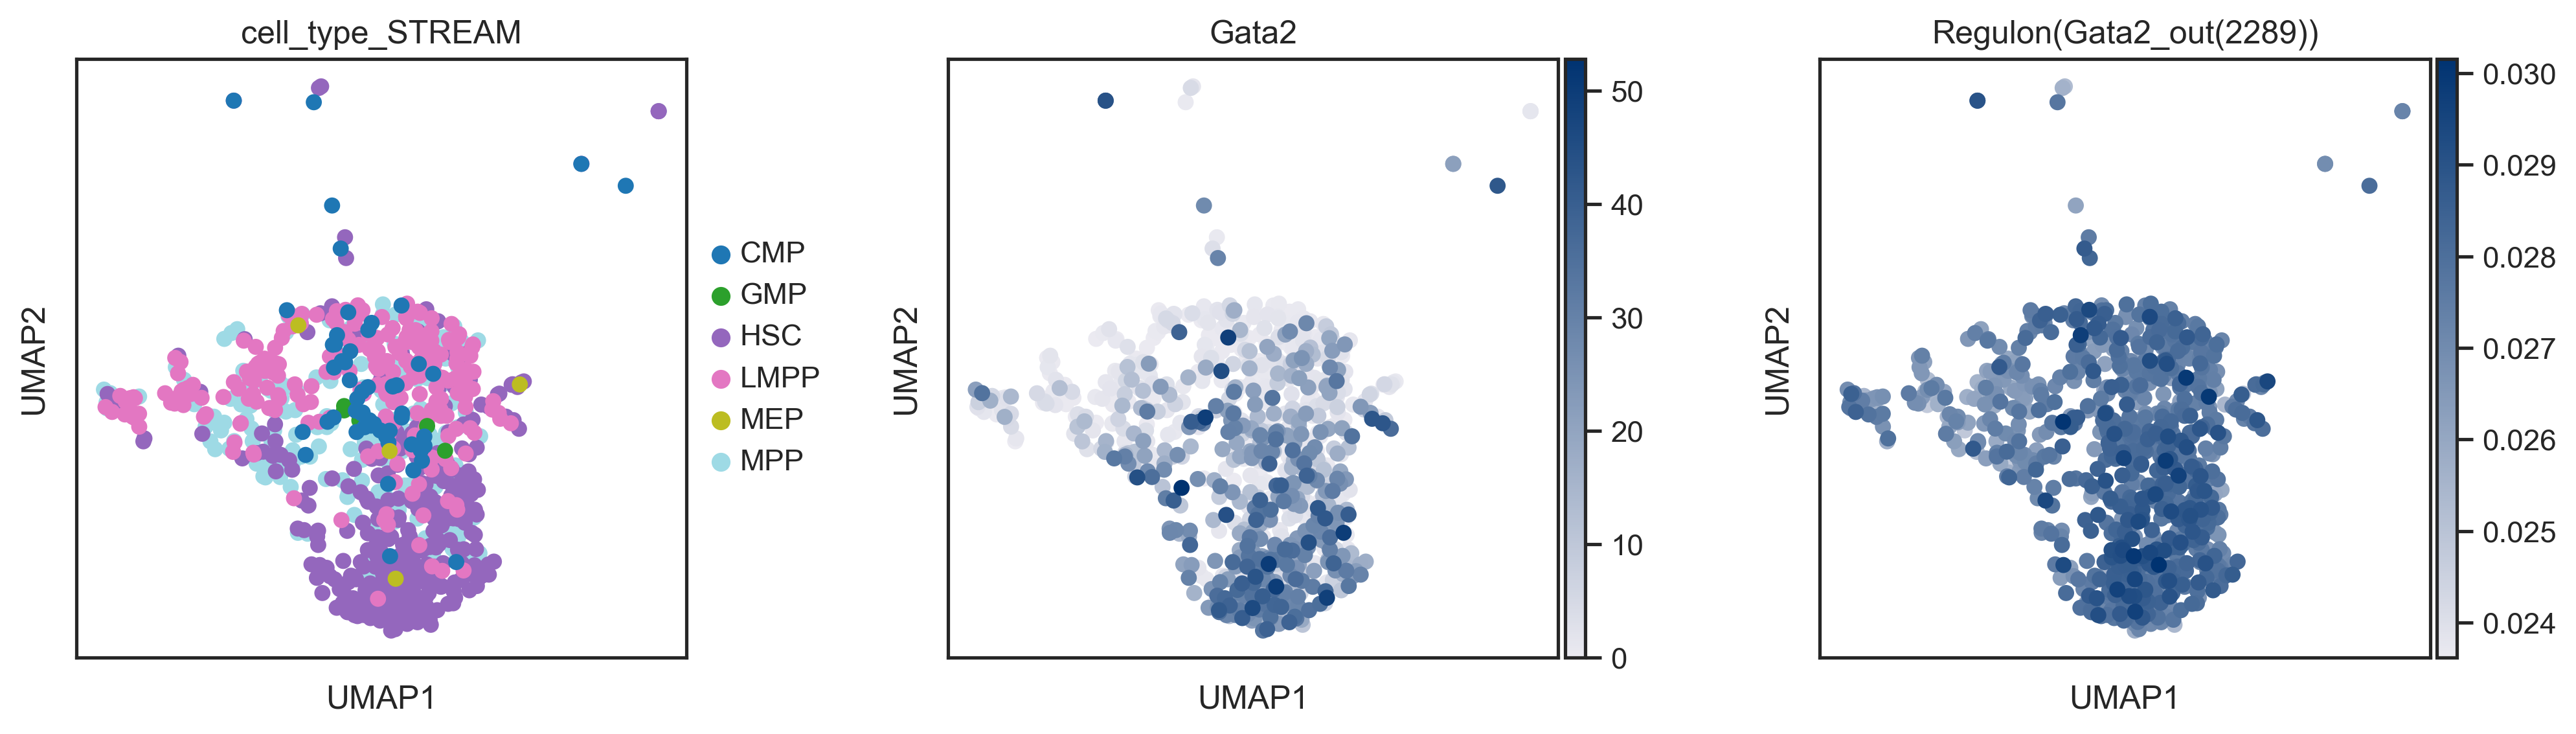

In [23]:
%matplotlib inline
color_map = mpl.colors.LinearSegmentedColormap.from_list('MyCmap',
                                                         [(0, '#ebeaf1'),
                                                          (1, '#003371')], N=256)
for i,v in regulon_selected.items():
    the_adata = adata_regulon[i]
    sc.tl.umap(the_adata, min_dist=0.35)
    with rc_context({'figure.figsize': (4, 4)}):
        sc.pl.umap(the_adata, color=['cell_type_STREAM', 'Gata2']+v, title=['cell_type_STREAM', 'Gata2']+v, color_map = color_map,
                   use_raw=False, ncols=4, frameon=True, show=False, wspace=0.3)

### - Network controllability analysis

In [24]:
# load the results of driver gene sets
import pickle
drivers_E = pickle.load(open(results_dir + 'Result_DriverSet_mHSC-E.pkl', 'rb'))
drivers_GM = pickle.load(open(results_dir + 'Result_DriverSet_mHSC-GM.pkl', 'rb'))
drivers_L = pickle.load(open(results_dir + 'Result_DriverSet_mHSC-L.pkl', 'rb'))

drivers = {'Erythroid':drivers_E, 'Granulocyte-Monocyte':drivers_GM, 'Lymphoid':drivers_L}

*> Veen diagrams for the basic information of driver genes*

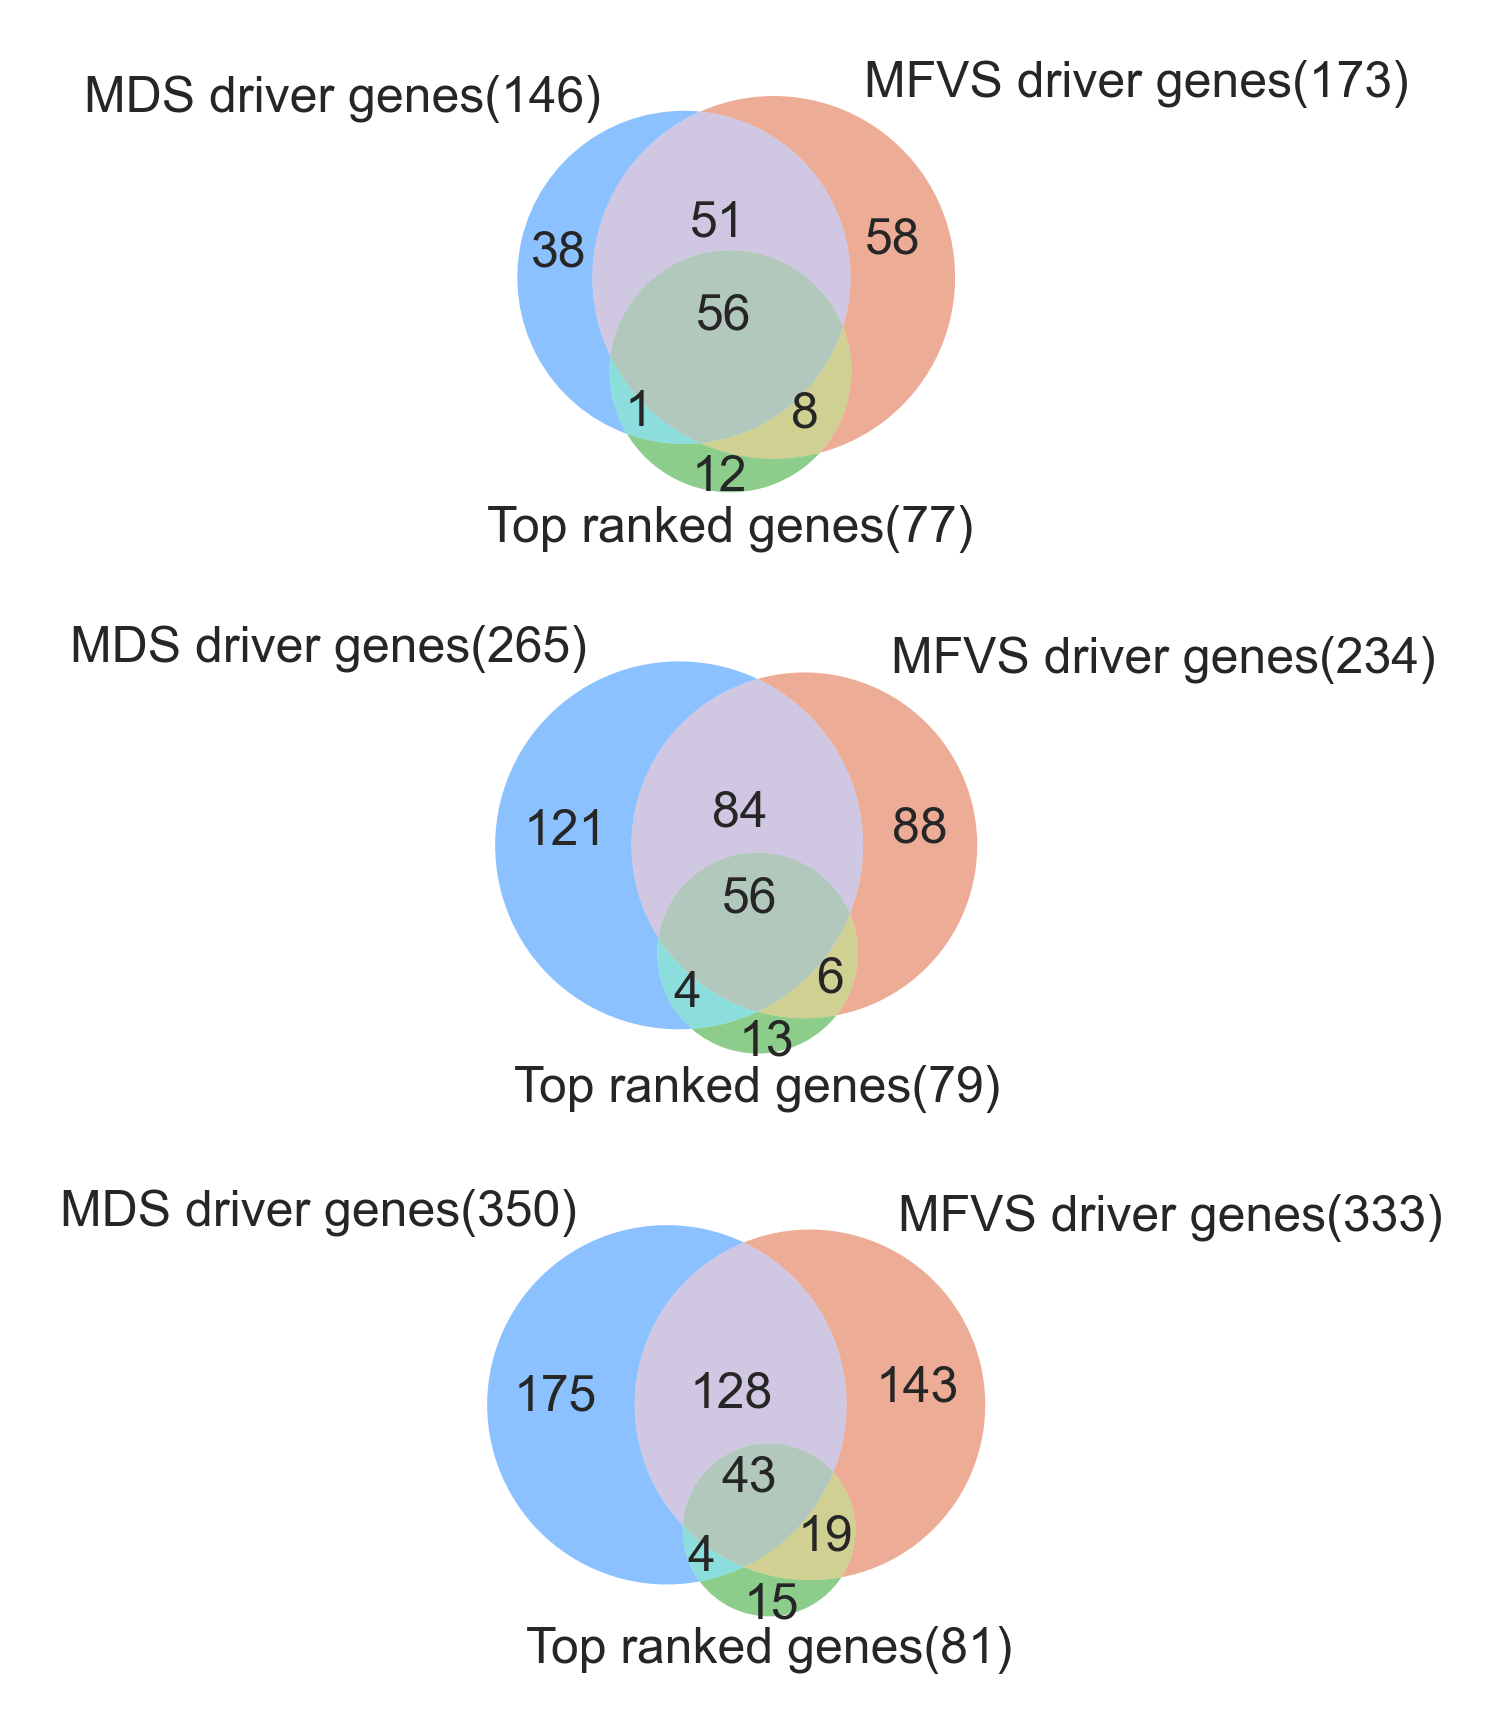

In [25]:
from matplotlib_venn import venn3
%matplotlib inline

fig = plt.figure(dpi=300,figsize=(8,3.5))
i = 1
for l,v in drivers.items():
    MDS_driver_set = v['MDS']
    DFVS_driver_set = v['MFVS']
    critical_genes = v['Critical']
    N_genes = v['N_genes']
    
    fig.add_subplot(3,1,i)
    out = venn3(subsets=[MDS_driver_set, DFVS_driver_set, critical_genes],
                set_labels=('MDS driver genes({})'.format(len(MDS_driver_set)),
                            'MFVS driver genes({})'.format(len(DFVS_driver_set)),
                            'Top ranked genes({})'.format(len(critical_genes))),
                 set_colors=('#0076FF','#D74715','#009000'),
                 alpha=0.45)
    for text in out.set_labels:
        if text is not None:
            text.set_fontsize(6)
    for text in out.subset_labels:
        if text is not None:
            text.set_fontsize(6)
    i = i+1

*> Controllability metrics*

In [26]:
def controllability_metrics(drivers_dict):
    MDS_driver_set = drivers_dict['MDS']
    DFVS_driver_set = drivers_dict['MFVS']
    critical_genes = drivers_dict['Critical']
    N_genes = drivers_dict['N_genes']
    driver_regulators = drivers_dict['drivers']
    
    # MDS controllability
    MDS_con = 1 - len(MDS_driver_set)/N_genes
    # MFVS controllability
    MFVS_con = 1 - len(DFVS_driver_set)/N_genes
    # Jaccard index
    Jaccard_con = len(MDS_driver_set.intersection(DFVS_driver_set))/len(MDS_driver_set.union(DFVS_driver_set))
    # driver regulators coverage
    Critical_con = len(driver_regulators)/len(MDS_driver_set.union(DFVS_driver_set))
    
    return MDS_con,MFVS_con,Jaccard_con,Critical_con

In [27]:
con_E = controllability_metrics(drivers['Erythroid'])
con_GM = controllability_metrics(drivers['Granulocyte-Monocyte'])
con_L = controllability_metrics(drivers['Lymphoid'])

con_df = pd.DataFrame(np.array([list(con_E),list(con_GM),list(con_L)]), columns=['MDS_controllability_score','MFVS_controllability_score','Jaccard index','Driver regulators coverage'])
con_df['Lineage'] = ['Erythroid','Granulocyte-Monocyte','Lymphoid']

con_df = pd.melt(con_df, id_vars=['Lineage'])

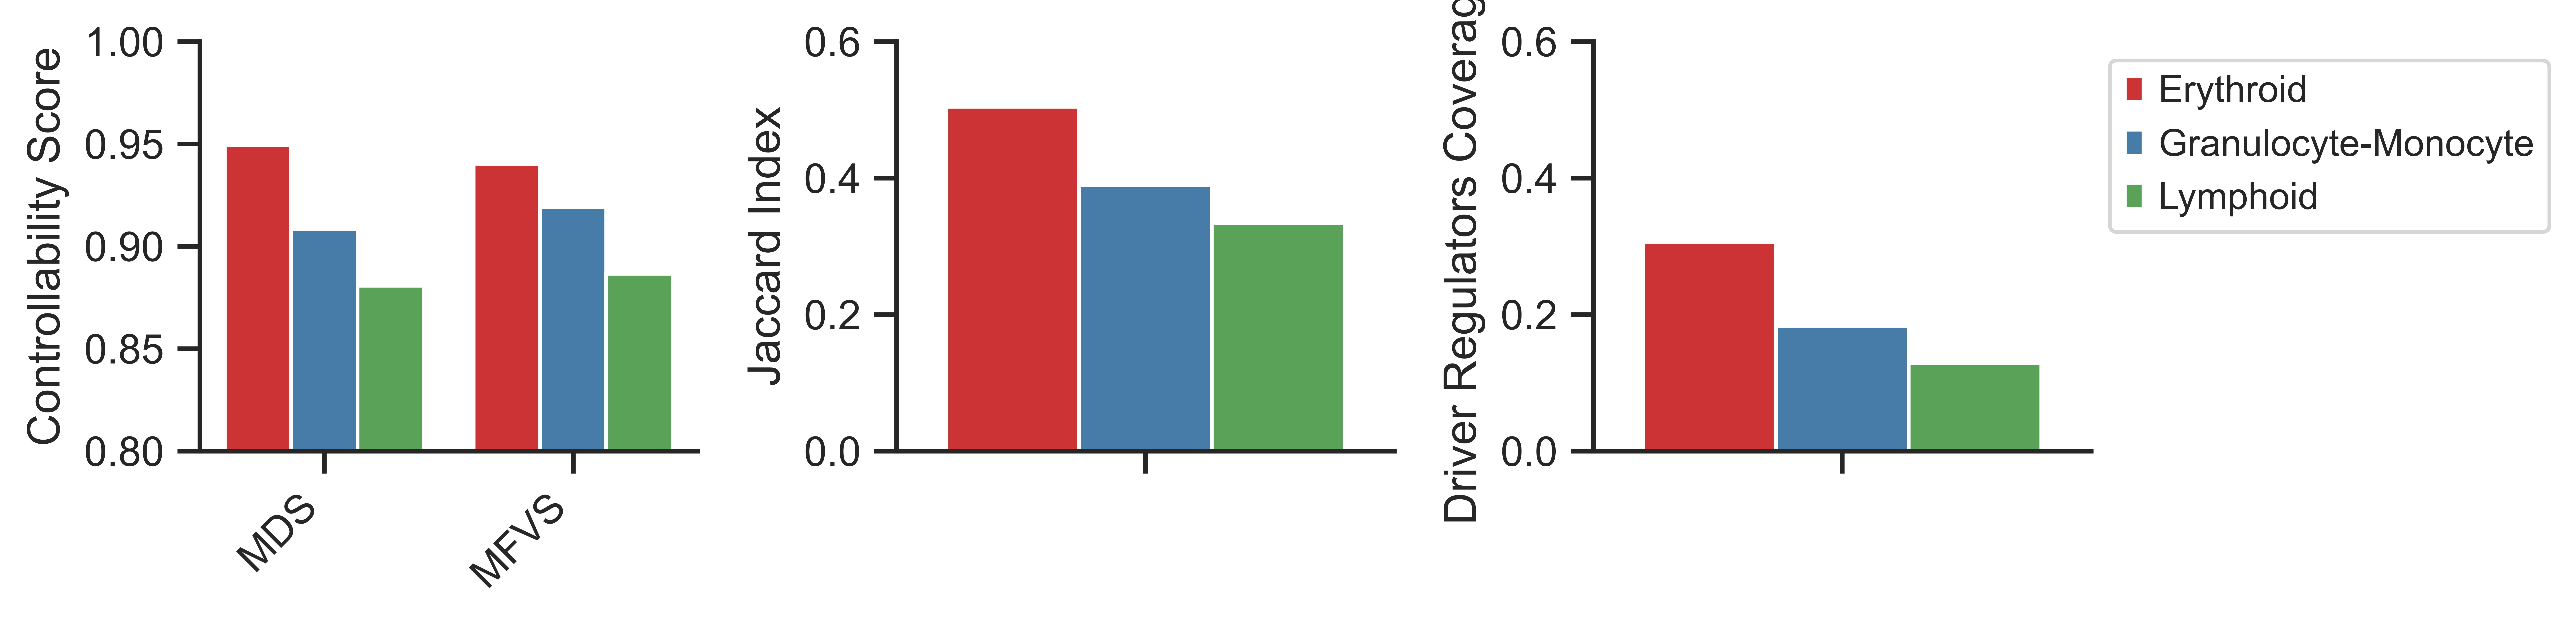

In [28]:
fig = plt.figure(dpi=600,figsize=(9,2)) 
sns.set_theme(style="ticks", font_scale=1.0)
surrent_palette = sns.color_palette("Set1")

# Controallability score
con_df1 = con_df.loc[con_df['variable'].isin(['MDS_controllability_score','MFVS_controllability_score'])]
fig.add_subplot(1,3,1)
ax1 = sns.barplot(x="variable", y="value", hue="Lineage", palette=surrent_palette,
                 data=con_df1)
ax1.set_xlabel('')
ax1.set_xticklabels(['MDS','MFVS'],rotation=45,ha="right")
ax1.set_ylabel('Controllability Score')
ax1.set_ylim(0.8,1.0)
sns.despine()
ax1.get_legend().remove()

# Jaccard index
con_df2 = con_df.loc[con_df['variable'].isin(['Jaccard index'])]
fig.add_subplot(1,3,2)
ax2 = sns.barplot(x="variable", y="value", hue="Lineage", palette=surrent_palette,
                 data=con_df2)
ax2.set_xlabel('')
ax2.set_xticklabels('')
ax2.set_ylabel('Jaccard Index')
ax2.set_ylim(0,0.6)
sns.despine()
ax2.get_legend().remove()

# Driver regulators coverage
con_df3 = con_df.loc[con_df['variable'].isin(['Driver regulators coverage'])]
fig.add_subplot(1,3,3)
ax3 = sns.barplot(x="variable", y="value", hue="Lineage", palette=surrent_palette,
                 data=con_df3)
ax3.set_xlabel('')
ax3.set_xticklabels('')
ax3.set_ylabel('Driver Regulators Coverage')
ax3.set_ylim(0,0.6)
sns.despine()
plt.legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='small')

plt.subplots_adjust(wspace = 0.4)